In [2]:
import pandas as pd
import geopandas as gpd
import sqlite3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from matplotlib.colors import ListedColormap
from rasterio.mask import mask
import rasterio


In [3]:

counties = gpd.read_file('counties.geojson')
wisco_counties = len(counties)
wisco_counties

72

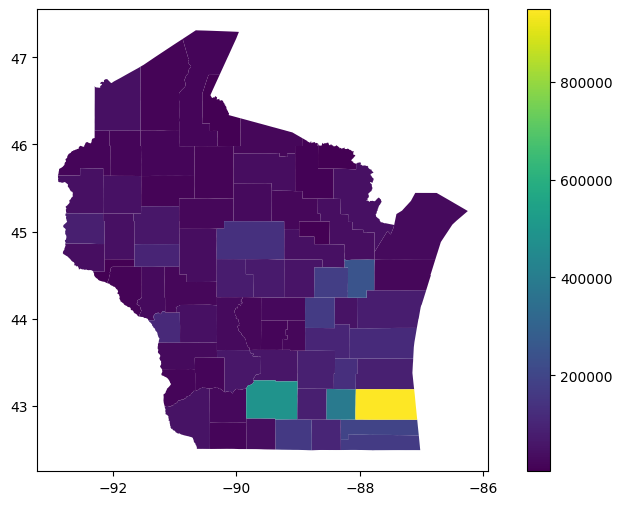

In [4]:

conn = sqlite3.connect("counties_tracts.db")
tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type='table'""", conn)
county_area_data = pd.read_sql("""SELECT * FROM counties""", conn)
counties = counties.merge(county_area_data, on='NAME')
train, test = train_test_split(counties, test_size=0.25,random_state=250)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
counties.plot(column='POP100', ax=ax, legend=True)
ax.set_xticks(np.arange(-92, -84, step=2))

plt.show()

In [5]:

county_list = test['NAME'].tolist()
county_list

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [6]:

model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.016720430179409274

In [7]:

km2 = 400 * 2.59 * 1e6
predicted_df = pd.DataFrame({"AREALAND": [km2]} )
predicted_df['predictedPOP'] = model.predict(predicted_df)
predicted_df['predictedPOP'][0]

90000.07422783462

In [8]:
 
hu100_df = pd.read_sql("""
SELECT counties.NAME, sum(HU100) as HU100
FROM tracts
INNER JOIN counties ON tracts.COUNTY = counties.COUNTY
GROUP BY counties.NAME
""", conn)

counties = pd.merge(counties, hu100_df, how = 'inner', on = 'NAME')
train, test = train_test_split(counties, random_state = 250, test_size = 0.25)

list(test['NAME'])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [9]:

hu100_values_dict = {county: counties.loc[counties['NAME'] == county, 'HU100'].values[0] for county in county_list if len(counties.loc[counties['NAME'] == county, 'HU100']) > 0}
hu100_values_dict

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [10]:

score = cross_val_score(model, train[["HU100"]], train["POP100"])
score.mean()

0.9739348181232653

In [11]:

score.std()

0.01693954236334351

In [12]:

model.fit(train[['HU100']], train['POP100'])

coef = round(model.coef_[0], 2)
intercept = round(model.intercept_, 2)

f"POP100 = {coef}*HU100 + {intercept}"

'POP100 = 2.47*HU100 + -9276.89'

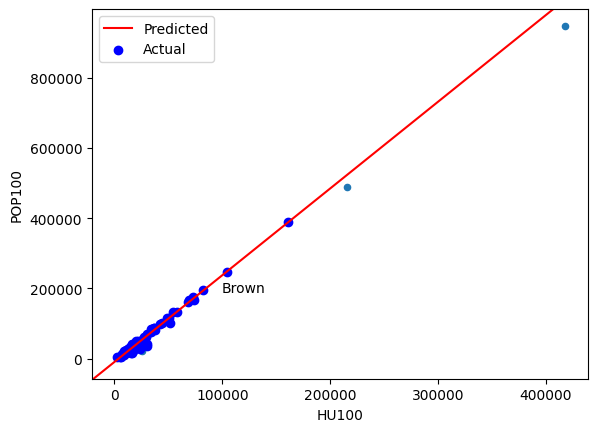

In [13]:

brown = counties.drop(columns = ["geometry", "AREALAND", 
                   "HU100"]).set_index('NAME').to_dict()["POP100"]['Brown County']

ax = counties.plot.scatter(x='HU100', y='POP100')
ax.axline((0, intercept), slope = coef, color = 'r', label = 'Predicted')
plt.scatter(train['HU100'], train['POP100'], color='blue', label='Actual')


brown_hu100 = train.loc[train['NAME'] == 'Brown County', 'HU100'].values[0]
brown_pop100 = train.loc[train['NAME'] == 'Brown County', 'POP100'].values[0]
plt.annotate('Brown', (brown_hu100, brown_pop100), textcoords="offset points", xytext=(12,-15), ha='center')


ax.legend(frameon=True)
None

In [14]:

A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
n3 = A >= 3
n6 = A <= 6

np.logical_and(n3,n6).astype(int).sum()

8

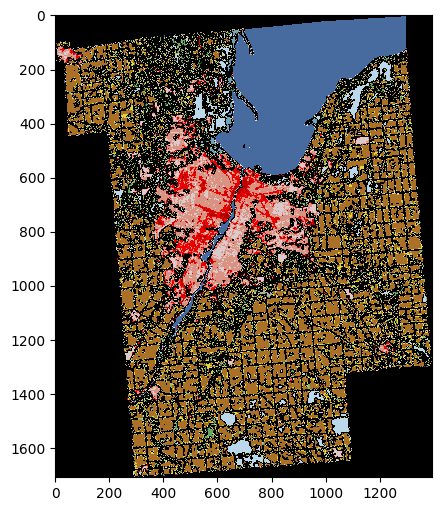

In [15]:

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip://../p6/land.zip!wi.tif")
brown = gpd.GeoDataFrame(counties.set_index("NAME")['geometry'].loc[["Brown County"]])

matrix, _ = mask(land, brown.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)


In [16]:

land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
total = (matrix != 0).astype(int).sum()
water = (matrix == land_use['open_water']).astype(int).sum()
water / total

0.13797526789725206

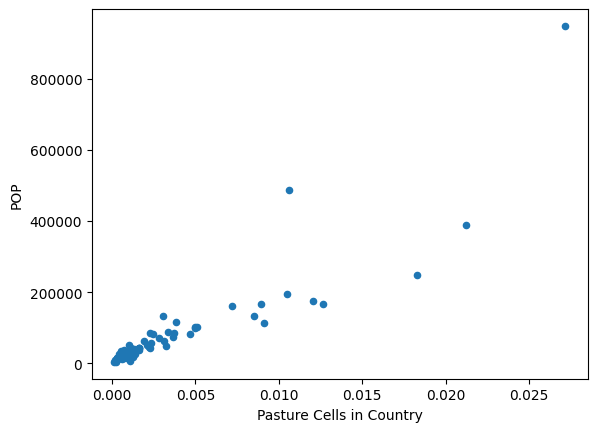

In [17]:

def check_proportion(counties, interest, col):
    counties = counties
    
    df = []
    num_key = land_use[interest]
    for county in counties[col]:
        geo_df = gpd.GeoDataFrame(counties.set_index("NAME")['geometry'].loc[[county]])
        matrix, _ = mask(land, geo_df.to_crs(land.crs)["geometry"], crop=True)
        matrix = matrix[0]
        check_area = (matrix == num_key).astype(int).sum()
        total_area = (matrix != 0).astype(int).sum()
        
        df.append(check_area / total_area)
    return df
df = check_proportion(counties, "developed_high", "NAME")
counties['prop'] = df
ax = counties.plot.scatter(x = "prop", y = "POP100")
ax.set_ylabel("POP")
ax.set_xlabel("Pasture Cells in Country")
None


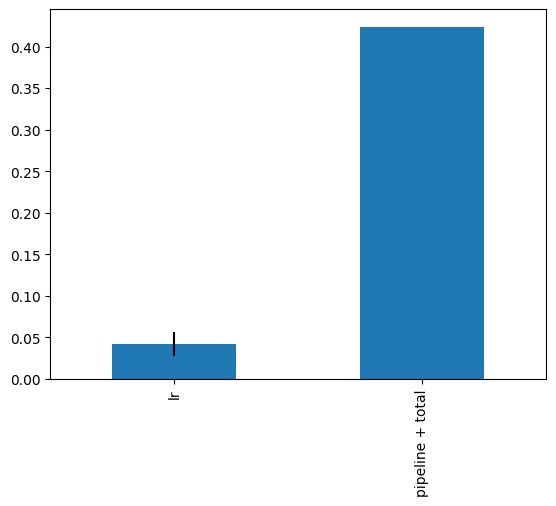

In [18]:

# I did this graph to try and show which model 1 or 2 would explain a variability better for the pop based on the land use. 
# By seeing what the relationship was between land use and pop, I tried to focus in POP100 for check2 to get the proportion and total area columns
# So that then I could make 2 models from it, one counting on linear regression and another on polynomial features
# Because the bar for LR is so low, this means that the pop is not linear and the bar for polynomial features is way better so we can use this for part 2
# Since it provides a better accuracy for getting above .35 for POP100

xdf = gpd.read_file("tracts.shp")

def check2(interest):
    num_key = land_use[interest]
    perc = []
    check_area_list = []
    for geoid in xdf['GEOID']:
        county = gpd.GeoDataFrame(xdf.set_index('GEOID')['geometry'].loc[[geoid]])
        matrix, _ = mask(land, county.to_crs(land.crs)["geometry"], crop=True)
        matrix = matrix[0]
        check_area = (matrix == num_key).astype(int).sum()
        check_area_list.append(check_area)
        area_total = (matrix != 0).astype(int).sum()
        perc.append(check_area / area_total)
    xdf[interest] = perc
    xdf[interest + "_total"] = check_area_list
    
check2("developed_med")

train, test = train_test_split(xdf, random_state = 250, test_size = 0.25)

m1 = LinearRegression()
m1.fit(train[["developed_med"]], train["POP100"])
scores1 = cross_val_score(m1, train[["developed_med"]], train["POP100"])

m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])

m2.fit(train[["developed_med_total"]], train["POP100"])
scores2 = cross_val_score(m2, train[["developed_med_total"]], train["POP100"])

avg = pd.Series({"lr": scores1.mean(), "pipeline + total": scores2.mean()})
std = pd.Series({"lr": scores1.std(), "pipeline  + total": scores2.std()})
ax = avg.plot.bar(yerr=std)
None

In [19]:

#This got a variance of 38.6% because since the graph above shows m2 being higher than m1, we know
# that there's a higher complexity that allows the model to fit a bigger range of patterns 
# + with the R^2 test above it's a given tho show how the model can fit the data we're testing
m2.score(test[["developed_med_total"]], test["POP100"])

0.38636869532318296